<a href="https://colab.research.google.com/github/nachofranco17/ProyectoCNN/blob/main/ProyectoCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
# --------------- Creando el directorio donde vamos a guardar el datset + imports necesarios --------------- #

import os, glob, json, textwrap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from google.colab import drive

drive.mount('/content/drive')

DRIVE_ROOT = "/content/drive/MyDrive"
PROJ_ROOT  = f"{DRIVE_ROOT}/ProyectoCNNv2"
os.makedirs(PROJ_ROOT, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# --- Construyendo un diccionario {basename -> ruta absoluta} que recorra images_001/images/*.png para acceder luego más rápido a cada foto individual ---

img_dirs = sorted(glob.glob(os.path.join(PROJ_ROOT, "images_*", "images")))
all_img_paths = []
for d in img_dirs:
    all_img_paths.extend(glob.glob(os.path.join(d, "*.png")))

img_index = {Path(p).name: p for p in all_img_paths}

print(f"Carpetas detectadas: {len(img_dirs)}")
print(f"Imágenes indexadas: {len(img_index):,}")

for i, (k,v) in enumerate(list(img_index.items())[:3]):
    print(i, "->", k, ":", v)

Carpetas detectadas: 12
Imágenes indexadas: 112,121
0 -> 00001089_000.png : /content/drive/MyDrive/ProyectoCNNv2/images_001/images/00001089_000.png
1 -> 00001090_000.png : /content/drive/MyDrive/ProyectoCNNv2/images_001/images/00001090_000.png
2 -> 00001088_020.png : /content/drive/MyDrive/ProyectoCNNv2/images_001/images/00001088_020.png


In [4]:
# --- Separando los valores de etiquetas multi-label de las enfermedades, pasándolas a binarias, recreando a partir de eso el nuevo dataset y agregando las rutas de cada foto ---

meta_path = os.path.join(PROJ_ROOT, "Data_Entry_2017.csv")
df = pd.read_csv(meta_path)

# Normalizando nombres de columnas
df.columns = [c.strip().replace(" ", "_") for c in df.columns] # Acá estamos reemplazando espacios en blanco por _ para evitar errores

# Clases del ChestX-ray14 (orden canónico)
CLASSES = [
    "Atelectasis","Cardiomegaly","Consolidation","Edema","Effusion",
    "Emphysema","Fibrosis","Hernia","Infiltration","Mass",
    "Nodule","Pleural_Thickening","Pneumonia","Pneumothorax"
]

# Definiendo función para aplicar luego en la columna Finding_Labels
def labels_to_vec(s):
    labs = [x.strip() for x in s.split("|")]
    vec = {c: 0 for c in CLASSES}
    if labs == ["No Finding"]:
        return vec
    for x in labs:
        if x in vec:
            vec[x] = 1
    return vec

# Creamos un dataframe con las enfermedades binarizadas
labels_expanded = df["Finding_Labels"].apply(labels_to_vec).apply(pd.Series)

# Unimos el dataframe anterior con otro que tenga columnas útiles
# Acá ya se podría eliminar la columna de las Finding_Labels (porque ya tenemos las 14 enfermedades binarizadas) pero la mantenemos a efectos de
# facilidad de lectura y para poder chequear que la binarización se hizo bien
# Luego, dejamos el Patient_ID para luego usarlo con el propósito de que los estudios de una persona vayan o al training o al validation o al test set y evitar un leakage donde el modelo reconozca
# al paciente en distintos sets en lugar de generalizar
df_ml = pd.concat([df[["Image_Index","Patient_ID","Finding_Labels"]], labels_expanded], axis=1)

# Agregando la ruta absoluta del archivo como un atributo más
df_ml["img_path"] = df_ml["Image_Index"].map(img_index.get)

# Viendo si hay imágenes faltantes físicamente (si hubiera)
missing_imgs = df_ml["img_path"].isna().sum()
print("Filas totales del dataset:", len(df_ml))
print("Imágenes con ruta encontrada:", len(df_ml) - missing_imgs)
print("Imágenes faltantes (no halladas en carpetas images_*):", missing_imgs)

df_ml.head(3)

Filas totales: 112120
Imágenes con ruta encontrada: 112120
Imágenes faltantes (no halladas en carpetas images_*): 0


,Image_Index,Patient_ID,Finding_Labels,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,img_path
0,00000001_000.png,1,Cardiomegaly,0,1,0,0,0,0,0,0,0,0,0,0,0,0,/content/drive/MyDrive/ProyectoCNNv2/images_00...
1,00000001_001.png,1,Cardiomegaly|Emphysema,0,1,0,0,0,1,0,0,0,0,0,0,0,0,/content/drive/MyDrive/ProyectoCNNv2/images_00...
2,00000001_002.png,1,Cardiomegaly|Effusion,0,1,0,0,1,0,0,0,0,0,0,0,0,0,/content/drive/MyDrive/ProyectoCNNv2/images_00...


In [11]:
# --- Viendo distribución de clases y contando cuántos casos no tienen nada ---

# Conteos por clase
counts = df_ml[CLASSES].sum().sort_values(ascending=False)
display(counts)

# Porcentaje de "No Finding"
no_finding_pct = (df_ml["Finding_Labels"] == "No Finding").mean()*100
print(f'% de "No Finding": {no_finding_pct:.2f}% = {len(df_ml)*(no_finding_pct/100)} imagenes')

,0
Infiltration,19894
Effusion,13317
Atelectasis,11559
Nodule,6331
Mass,5782
Pneumothorax,5302
Consolidation,4667
Pleural_Thickening,3385
Cardiomegaly,2776
Emphysema,2516


% de "No Finding": 53.84% = 60361.0 imagenes


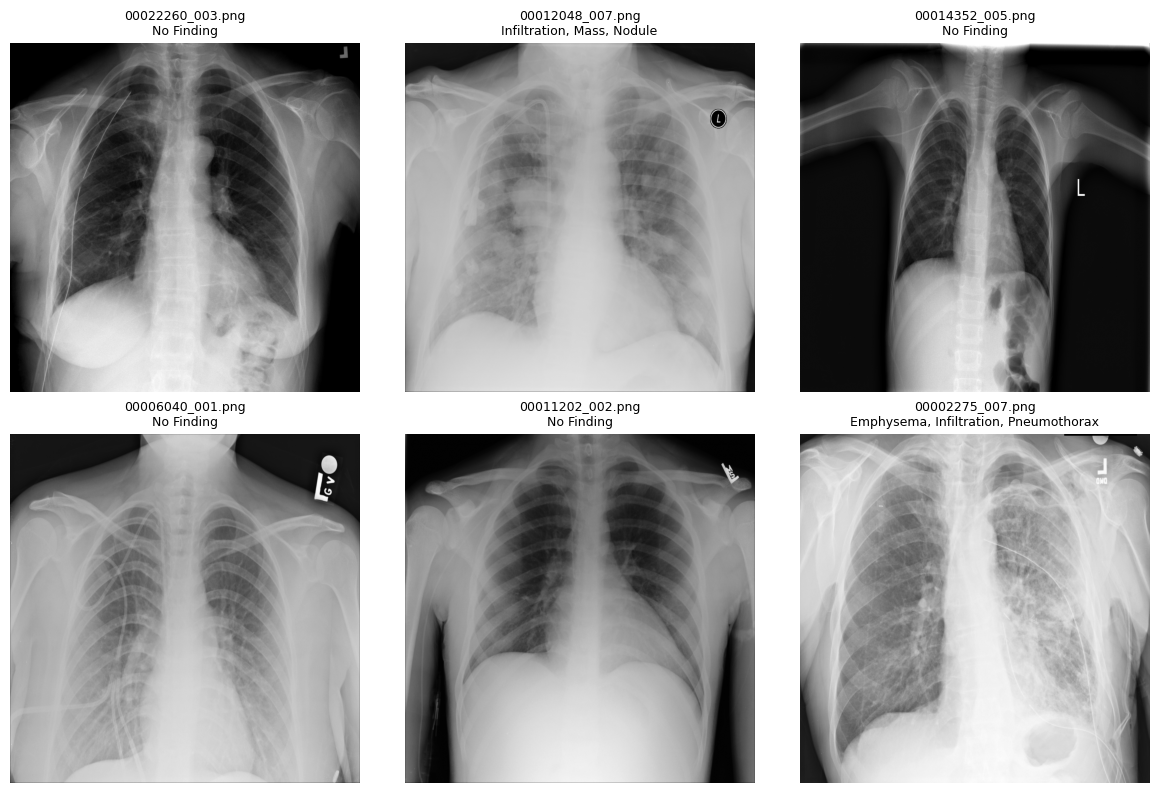

In [15]:
# --- Viendo algunas imagenes de muestra con sus etiquetas (enfermedades o no presentes) ---

samples = df_ml.sample(6, random_state=42)

plt.figure(figsize=(12,8))
for i, (_, row) in enumerate(samples.iterrows(), 1):
    img = plt.imread(row["img_path"])
    labs = [c for c in CLASSES if row[c]==1]
    plt.subplot(2,3,i)
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    title = row["Image_Index"] + ("\n" + ", ".join(labs) if labs else "\nNo Finding")
    plt.title(title, fontsize=9)
plt.tight_layout()
plt.show()

In [17]:
# --- Guardando un CSV limpio para siguientes pasos ---

out_path = os.path.join(PROJ_ROOT, "df_metadata_indexado.csv")
df_ml.to_csv(out_path, index=False)
print("✅ Archivo guardado en:", out_path)

✅ Archivo guardado en: /content/drive/MyDrive/ProyectoCNNv2/df_metadata_indexado.csv
